# *K-means* e *bisecting K-means* 

O objetivo deste projeto é realizar uma análise qualitative entre o K-means e o bisecting K-means. As bases de dados utilizadas serão a [Iris Dataset](https://archive.ics.uci.edu/ml/datasets/iris) e o [Wine Dataset](http://archive.ics.uci.edu/ml/datasets/Wine).

O pré-processamento e o estudo da redução de dimensionalidade foram executados no arquivo [Normalização_e_seleção_de_features](Normalização_e_seleção_de_features.ipynb)


In [1]:
from sklearn import metrics
from time    import time
from math    import sqrt,sin
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import random            as rd


metric = metrics.silhouette_score
    
# Argumentos e pré-definições do seaborn
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set(style="ticks")

filepath_iris = '../data/Iris-norm.csv'
filepath_wine = '../data/wine.csv'

iris_df = pd.read_csv(filepath_iris)

In [2]:
def plotter(doc, ks, label):
    X,Y,L = zip(*doc)

    kx,ky = zip(*ks)
    plt.scatter(x=X,y=Y, marker='o', c=label, cmap='gist_rainbow')
    plt.scatter(x=kx, y=ky, marker='x', color='black', s=150)
    
def plotter2(doc):
    X,Y = zip(*doc)
    plt.scatter(x=X,y=Y, marker='o', cmap='gist_rainbow')
    
def plotter3(doc, label, ks=None):
    X,Y = zip(*doc)
    plt.scatter(x=X,y=Y, marker='o', c=label, cmap='gist_rainbow')
    if ks is not None:
        kx,ky = zip(*ks)
        plt.scatter(x=kx, y=ky, marker='x', color='black', s=150)

In [3]:
def euclidianDistance(p1, p2):
    return sqrt( (p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 )

In [4]:
def SSE(centroids, data):
    sum_sq_err = 0
    for centroid in centroids:
        for p in data:
            sum_sq_err += (euclidianDistance(centroid, p) ** 2)
            
    return sum_sq_err

In [5]:
MAX_ITER = 60
def breakCondition(old_centroids, curr_centroids,itter, data, min_gain):
    if itter >= MAX_ITER: return True
    
    old_sse = SSE(old_centroids, data)
    cur_sse = SSE(curr_centroids, data)
    
#     print(abs(old_sse - cur_sse))
    if abs(old_sse - cur_sse) < min_gain:
        return True
    
    return False

In [6]:
def defineNewCentroids(S, old_centroids, dist_func):
    color = {cen:i for i,cen in enumerate(old_centroids)}
    centroids = dict()
    labels = []
    groups = {}
    
    for p in S:
        distances = [(dist_func(p, centroid), centroid) for centroid in old_centroids]
        closest_centroid = min(distances, key=lambda x: x[0])[1]
        
        label = color[closest_centroid]
        labels.append(label)
        
        
        if label not in centroids:
            centroids[label] = {"x":p[0], "y":p[1], "len":1, "points":[p]}
        else:
            centroids[label]["x"] += p[0]
            centroids[label]["y"] += p[1]
            centroids[label]["len"] += 1
            centroids[label]["points"].append(p)
 
    new_centroids = [(c['x']/c['len'], c['y']/c['len']) for c in centroids.values()]

    return new_centroids,labels,[centroids[c]['points'] for c in centroids]

In [7]:
def getRandomCentroids(S, k, existing=False):
    if existing:
        return [tuple(s) for s in rd.sample(S, k)]
    else:
        maxxy = [max(S, key=lambda x: x[0])[0], max(S, key=lambda x: x[1])[1]]
        return [(rd.random()*maxxy[0], rd.random()*maxxy[1]) for _ in range(k)]

In [8]:
def kmeans(S, k, dist_func=euclidianDistance, min_gain=0.00001):
    curr_centroids = getRandomCentroids(S, k, existing=True)
    old_centroids  = getRandomCentroids(S, k, existing=False)
    itter = 0
    predicted = []
    groups = []
    
    while True:
        old_centroids = curr_centroids       
        curr_centroids,predicted,groups = defineNewCentroids(S, old_centroids, dist_func)
        itter += 1
        if breakCondition(old_centroids, curr_centroids, itter, S, min_gain):
            break
        
    return predicted,old_centroids,groups

Melhor valor para o K:   3
Obtendo uma acurácia de: 0.8856970310281228 (adjusted_rand_score)
Tempo: 7.6877686977386475


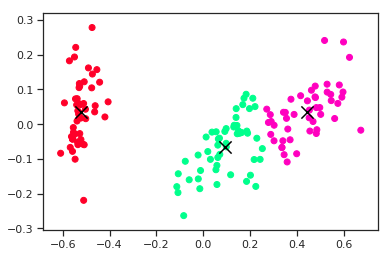

In [9]:
d1 = list(iris_df.PCA1)
d2 = list(iris_df.PCA2)

maping = {key:count for count,key in enumerate(iris_df.species)}
Y = [maping[i] for i in iris_df.species]


document = list(zip(d1,d2,Y))

best_accuracy = -2
best_centr = []
best_k = -1
best_label = []
inicio = time()
accuracy = 0

metric = metrics.adjusted_rand_score
# metric = metrics.v_measure_score

for _ in range(15):
    k_acc = []
    for K in range(1, 20):
        y_pred, centroids, _ = kmeans(document, K, euclidianDistance)

        accuracy = metric(Y, y_pred)
    
        if accuracy >= best_accuracy:
            best_accuracy = accuracy
            best_centr = centroids
            best_k = K
            best_label = y_pred
    
final = time()
    
print(f"Melhor valor para o K:   {best_k}\nObtendo uma acurácia de: {best_accuracy} ({metric.__name__})\nTempo: {final-inicio}")
plotter(document, best_centr, best_label)

In [10]:
y_pred, centroids, group = kmeans(document, 3, euclidianDistance)

Time: 1.7392001152038574

Gráfico: K por Acurácia (adjusted_rand_score)


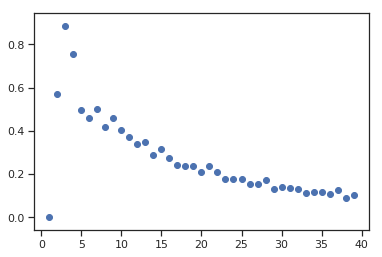

In [11]:
k_acc = []
acc,y_pred = 0,0

inicio = time()

metric = metrics.adjusted_rand_score
# metric = metrics.v_measure_score

for K in range(1, 40):
    y_pred, _,_ = kmeans(document, K, euclidianDistance)
    acc = metric(Y, y_pred)
    k_acc.append([K, acc])
    

final = time()

plotter2(k_acc)

print(f"Time: {final-inicio}\n\nGráfico: K por Acurácia ({metric.__name__})")

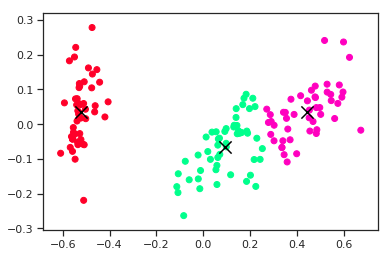

In [12]:
y_pred, centroids,_ = kmeans(document, 3, euclidianDistance, min_gain=0.00001)
# print(document)
plotter(document, centroids, y_pred)

## *bisecting K-means* 

In [13]:
# def sumSquaredErrors(data, centroids):

"""Return cordinate of a centroid"""
def getCentroid(data):
    return np.mean(data, 0)


"""Calculate the SSE of the given data."""
def sse(data):
    u = getCentroid(data)
    return np.sum(np.linalg.norm(data - u, 2, 1))


In [14]:
def dataToCluster(datas, labels, lcen):
    new_C = [None] * lcen
    
    for y,p in zip(labels,datas):
        if new_C[y] == None:
            new_C[y] = [p[:-1]]
        else:
            new_C[y].append(p[:-1])
    
    return new_C

In [15]:
a = dataToCluster([[1, 2, 'A'], [3, 4, 'A'], [6,7, 'A']], [0, 1, 1], 2)
a

[[[1, 2]], [[3, 4], [6, 7]]]

In [16]:
def BKM(data, distance_function=euclidianDistance, min_profit=0.01, MAX_K=8):
    
    C = [data]
    K = 1
    gain = 0.001
    current_data = []
    
    while True:
        sse_for_all_clusters = np.array([sse(cluster) for cluster in C])
        old_sse = np.sum(sse_for_all_clusters)
        
        current_data = C.pop(np.argmax(sse_for_all_clusters))
        K += 1
        
        y_pred, centroids, groups = kmeans(current_data, 2, distance_function)
        
        C.append(groups[0])
        C.append(groups[1])
        
        sse_for_all_clusters = np.array([sse(cluster) for cluster in C])
        new_sse = np.sum(sse_for_all_clusters)
        
        gain = (old_sse - new_sse)
        
        if K >= MAX_K or gain < min_profit:
            break
            
    final_centroids = [getCentroid(np.array(group)).tolist() for group in C]
    
    X, labels = [], []
    for i,group in enumerate(C):
        X.extend(group)
        labels.extend([i] * len(group))
    
    return labels,final_centroids,C
        

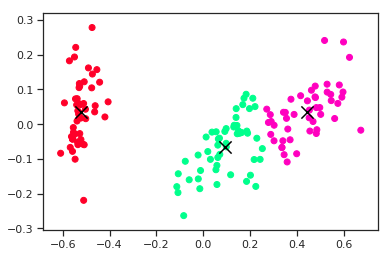

In [17]:
d1 = list(iris_df.PCA1)
d2 = list(iris_df.PCA2)

document = list(zip(d1,d2))

_,centroids,groups2 = BKM(document, MAX_K=3)

labels = []
X = []
for i,group in enumerate(groups2):
    X.extend(group)
    labels.extend([i] * len(group))

plotter3(X,labels,ks=centroids)

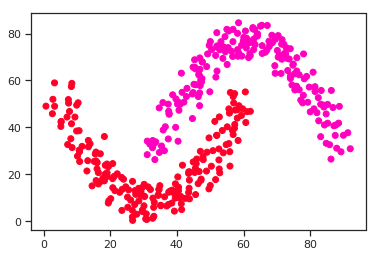

In [18]:
fx1 = lambda x: 4*x   +(1.2*rd.random()) *8
fx2 = lambda x: 4*x   +29+(1.2*rd.random()) *8

fy1 = lambda y: ((y-7) **2) + 15*rd.random()
fy2 = lambda y: ((-(((y-7)) **2))) + 70 + 15*rd.random()
label = []

alcance = np.arange(0, 14.0, 0.07)

X  = [(fx1(i),fy1(i)) for i in alcance]
label += [1]*len(X)

X += [(fx2(i),fy2(i)) for i in alcance]
label += [2]*len(alcance)

plotter3(X, label)
plt.savefig('conchas.pdf')

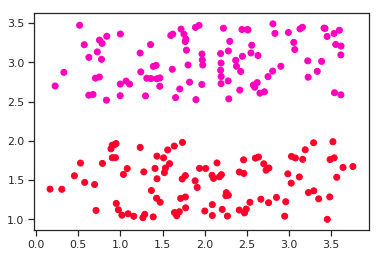

In [19]:
alcance2 = np.arange(0, 3, 0.03)
label_sq = [] 
X2 =  [(i+rd.random(), 1+rd.random()) for i in alcance2]
label_sq += [1]*len(X2)

X2 += [(i+rd.random(), 2.5+rd.random()) for i in alcance2]
label_sq += [2]*len(alcance2)

plotter3(X2, label_sq)
plt.savefig('blocks.pdf')

71


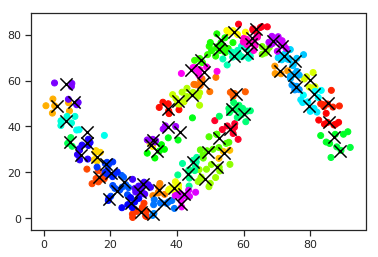

In [20]:
labels,centroids,groups2 = BKM(X, MAX_K=1000, min_profit=4)


X = []
for i,group in enumerate(groups2):
    X.extend(group)

print(len(centroids))
plotter3(X,labels, ks=centroids)

2


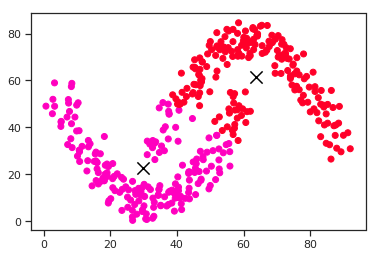

In [21]:
y_pred, centroids, _ = kmeans(X, 2, euclidianDistance)
print(len(centroids))
plotter3(X, y_pred, ks=centroids)

Melhor valor para o K:   49
Obtendo uma acurácia de: 0.1864662107049732 (v_measure_score)
Tempo: 28.81416344642639


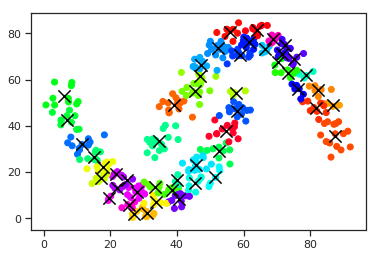

In [22]:
best_accuracy = -2
best_centr = []
best_k = -1
best_label = []
inicio = time()
accuracy = 0
Y = label
# metric = metrics.adjusted_rand_score
metric = metrics.v_measure_score

# for _ in range(3):
k_acc = []
for K in range(1, 50):
    y_pred, centroids, _ = kmeans(X, K, euclidianDistance)

    accuracy = metric(Y, y_pred)

    if accuracy >= best_accuracy:
        best_accuracy = accuracy
        best_centr = centroids
        best_k = K
        best_label = y_pred
    
final = time()
    
print(f"Melhor valor para o K:   {best_k}\nObtendo uma acurácia de: {best_accuracy} ({metric.__name__})\nTempo: {final-inicio}")
plotter3(X, best_label, ks=best_centr)

In [23]:
def kfold_test(X, label, k=2, means='classic', minimal_profit=100):
    accuracies = []
    document = X
    y_true = label

    for N in range(1, 2):
        kfold = KFold(n_splits=10, shuffle=True, random_state=42)
        for train_index, test_index in kfold.split(document, y_true):
            document_train = []
            y_train_true = []
            for i in train_index:
                document_train.append(document[i])
                y_train_true.append(y_true[i])
                
            if means == 'classic':
                pred_train_KM,_,_ = kmeans(document_train, k)
            elif means == 'bisect':
                pred_train_KM,_,_ = BKM(document_train, MAX_K=100, min_profit=minimal_profit)

            accuracy_train = metrics.v_measure_score(y_train_true, pred_train_KM)

            document_test = []
            y_test_true = []
            for i in test_index:
                document_test.append(document[i])
                y_test_true.append(y_true[i])
            
            if means == 'classic':
                pred_test_KM,_,_ = kmeans(document_test, k)
            elif means == 'bisect':
                pred_test_KM,_,_ = BKM(document_test, MAX_K=100, min_profit=minimal_profit)

            accuracy_test = metrics.v_measure_score(y_test_true, pred_test_KM)
            accuracies.append(accuracy_test)

    print(np.mean(np.array(accuracies)))

In [24]:
kfold_test(X, label, k=2)

0.030080523937850885


In [25]:
kfold_test(X, label, means='bisect')

0.5031711650077784
